In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import json, pymongo, pandas
import numpy as np

In [3]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def connect_to_database(): 
    # load credentials to access the database, connect, identify collection
    data = json.load(open('./.credentials/auth.json'))
    mongo_tunnel = 'mongodb://' + data['user'] + ':' + data['password'] + '@127.0.0.1'
    connection = pymongo.MongoClient(mongo_tunnel)
    data_base = connection['sleep_affect_memory']
    collection = data_base['replication']
    return collection

In [5]:
def identify_workers(collection):
    
    # the second is my worker id
    exclude = ['NONE', 'A33F2FVAMGJDGG']
    all_workers = [i for i in collection.distinct('worker_id') if i not in exclude]
    
    # extract workers who've completed entire experiment -- not returned HIT early
    complete = [] 
    for i_worker in all_workers: 
        tmp_data = collection.find({'worker_id':i_worker})
        if 'worker_feedback' in tmp_data[tmp_data.count()-1]['trial_data']: 
            complete.append(i_worker)
    
    return complete

In [6]:
def extract_data(w_ids): 
    
    # columns to exclude 
    ignore = ['trial_index', 
              'time_elapsed', 
              'stimulus', 
              'correct_response', 
              'internal_node_id', 
              'trial_type']
    
    subject_trial_data = pandas.DataFrame()
    
    # iterate over workers 
    for i_worker in w_ids: 
        
        # extract worker's data from mongo database
        i_data = collection.find({'worker_id':i_worker})

        for one_trial in i_data: 
            
            # extract all data we want 
            if 'worker_feedback' not in one_trial['trial_data'].keys(): 
                q = {i:one_trial['trial_data'][i] for i in list(one_trial['trial_data'].keys()) if i not in ignore}
                q['subject'] = one_trial['worker_id']
                subject_trial_data = subject_trial_data.append(q, ignore_index=True)
    
    # convert to absolute value of distance
    subject_trial_data.distance = np.abs(subject_trial_data.distance)
    
    return subject_trial_data

In [7]:
collection = connect_to_database()
worker_ids = identify_workers(collection)
trial_data = extract_data(worker_ids)

In [18]:
generalization_data = trial_data[trial_data.stage=='generalization']
generalization_data = generalization_data[generalization_data.valence!='control']

In [19]:
generalization_data

,condition,correct,frequency,i_acquisition_trial,i_block,key_press,rt,stage,subject,valence,distance,i_generalization_trial
33,NaN,0.0,NaN,NaN,0.0,80,800,generalization,A2CUBA783W1689,positive,5.0,0.0
34,NaN,0.0,NaN,NaN,0.0,80,321,generalization,A2CUBA783W1689,positive,5.0,1.0
35,NaN,0.0,NaN,NaN,0.0,80,275,generalization,A2CUBA783W1689,positive,20.0,2.0
36,NaN,0.0,NaN,NaN,0.0,80,69,generalization,A2CUBA783W1689,negative,0.0,3.0
37,NaN,1.0,NaN,NaN,0.0,32,527,generalization,A2CUBA783W1689,negative,20.0,4.0
38,NaN,0.0,NaN,NaN,0.0,81,1856,generalization,A2CUBA783W1689,negative,5.0,5.0
39,NaN,0.0,NaN,NaN,0.0,80,1108,generalization,A2CUBA783W1689,positive,20.0,6.0
42,NaN,1.0,NaN,NaN,0.0,32,864,generalization,A2CUBA783W1689,positive,100.0,9.0
43,NaN,0.0,NaN,NaN,0.0,81,1118,generalization,A2CUBA783W1689,negative,100.0,10.0
44,NaN,1.0,NaN,NaN,0.0,80,895,generalization,A2CUBA783W1689,positive,0.0,11.0


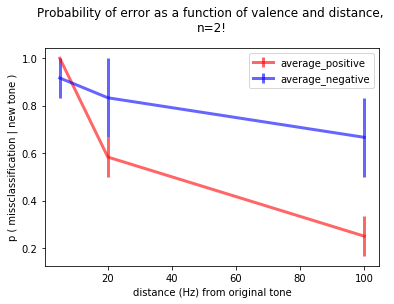

In [29]:
tones =  [i for i in np.sort(generalization_data.distance.unique()) if i != 0 ]
valences = ['positive', 'negative']
generalization_curves = {j:{i:[] for i in tones} for j in valences}
colores = {'positive':'red', 'negative':'blue'}

need_legend = 1
for i_subject in worker_ids: 
    
    gen_data = generalization_data[generalization_data.subject==i_subject]
    
    for i_valence in valences: 
        
        generalization_curve = []
        for i_tone in tones: 

            conditions = (gen_data.valence == i_valence) & (gen_data.distance == i_tone)
            generalization_curve.append(1-gen_data[conditions].correct.mean())
            generalization_curves[i_valence][i_tone].append(1-gen_data[conditions].correct.mean())
        
        #plot(tones, generalization_curve,  color=colores[i_valence], linewidth=2, alpha=.1)

for i_valence in valences: 
    errorbar(tones, 
             [mean(generalization_curves[i_valence][i]) for i in tones],
             yerr=[std(generalization_curves[i_valence][i]) for i in tones], 
             color=colores[i_valence], linewidth=3, label='average_%s'%i_valence, 
             alpha=.6)
legend() 
ylabel('p ( missclassification | new tone )')
xlabel('distance (Hz) from original tone'); 
title('Probability of error as a function of valence and distance, \nn=2!', y=1.05); 

In [30]:
main_question_conditions = (generalization_data.valence != 'control')
valence_by_distance = generalization_data[main_question_conditions][['correct', 'distance', 'valence']]

In [31]:
from statsmodels.formula.api import ols
model = ols("correct ~ distance * valence", valence_by_distance).fit()

In [32]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3.069
Date:                Wed, 28 Nov 2018   Prob (F-statistic):             0.0312
Time:                        18:29:49   Log-Likelihood:                -72.606
No. Observations:                 108   AIC:                             153.2
Df Residuals:                     104   BIC:                             163.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       